In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftn, ifftn, dct, idct
from scipy.sparse import spmatrix
from scipy.optimize import minimize, LinearConstraint
import cvxpy as cp

In [2]:
def zero_one(arr):
    res = np.log1p(abs(arr))
    res /= np.max(res)
    return res

def plot_rgb(img):
    zo = zero_one(img)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, c in enumerate("red green blue".split()):
        ax[i].set_title(c)
        ax[i].imshow(zo[:, :, i])

In [3]:
ballot = plt.imread("ballot.tif", format="tif").astype(int)
ballot_fft = fftn(ballot, axes=(0,1))

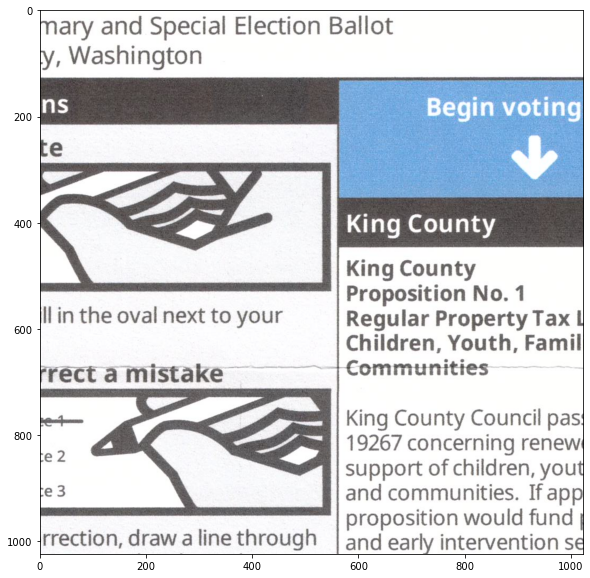

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(ballot)

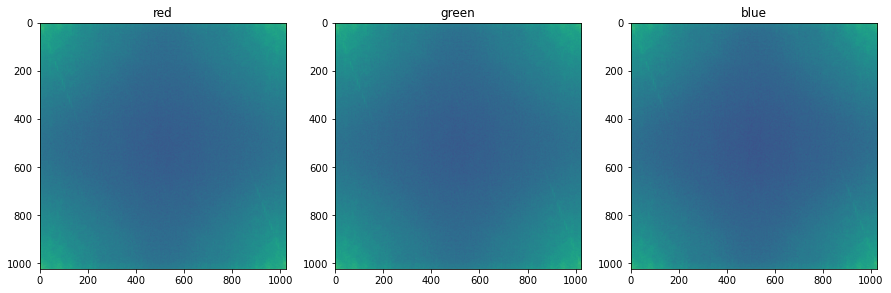

In [5]:
plot_rgb(ballot_fft)

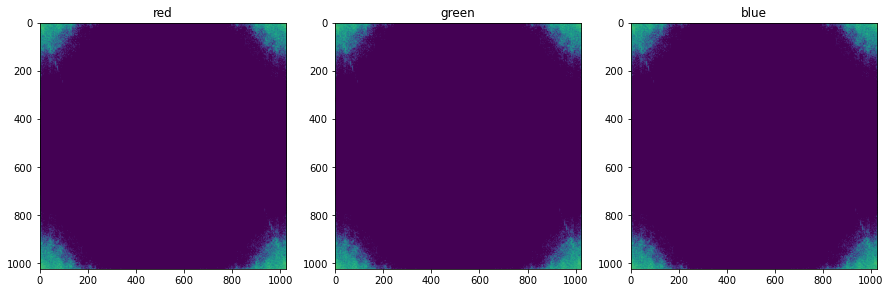

In [6]:
ratio = 20
n_keep = np.prod(ballot.shape) // ratio

# np.argpartition(np.abs(ballot_fft).flatten(), kth=range(n_keep))
keep_idx = np.argsort(np.abs(ballot_fft).flatten())[-n_keep:]

ballot_comp = np.zeros(ballot.size, dtype=complex)
ballot_comp[keep_idx] = ballot_fft.flatten()[keep_idx]
ballot_comp.shape = ballot.shape

plot_rgb(ballot_comp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


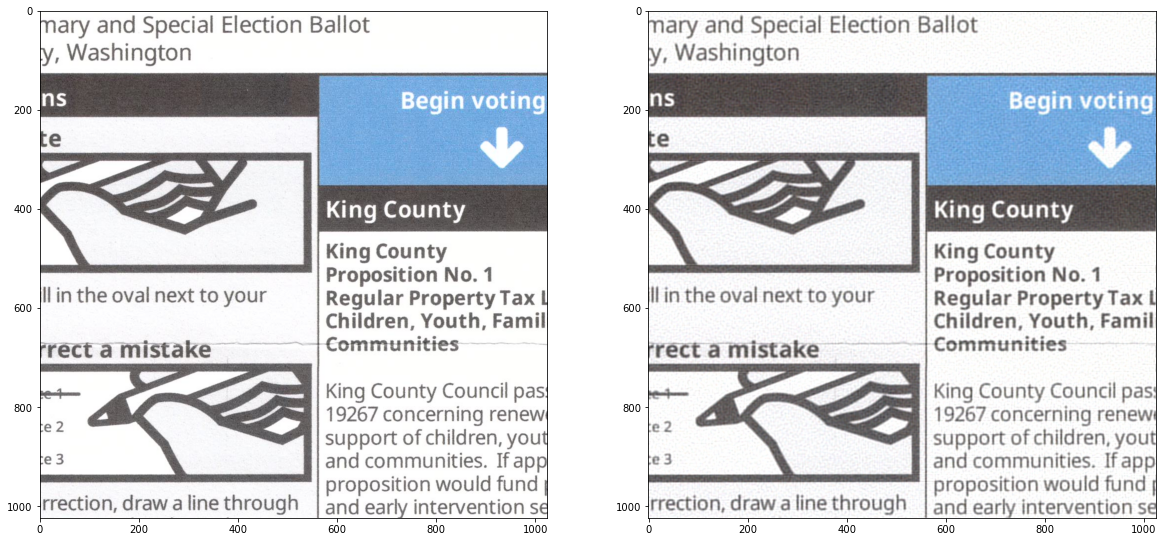

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(ballot)
ax[1].imshow(ifftn(ballot_comp, axes=(0, 1)).real.astype(int))

## Denoising

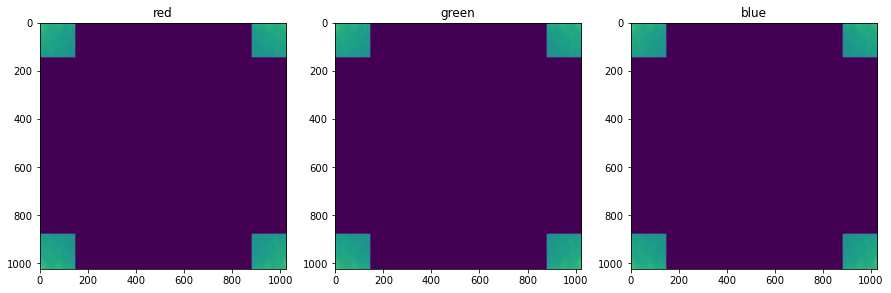

In [8]:
ballot_denoised = np.array(ballot_fft)
rat = 7
n_trim0, n_trim1 = ballot_denoised.shape[0] // rat, ballot_denoised.shape[1] // rat

ballot_denoised[n_trim0:-n_trim0, :, : ] = 0
ballot_denoised[:, n_trim1:-n_trim1, : ] = 0

plot_rgb(ballot_denoised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


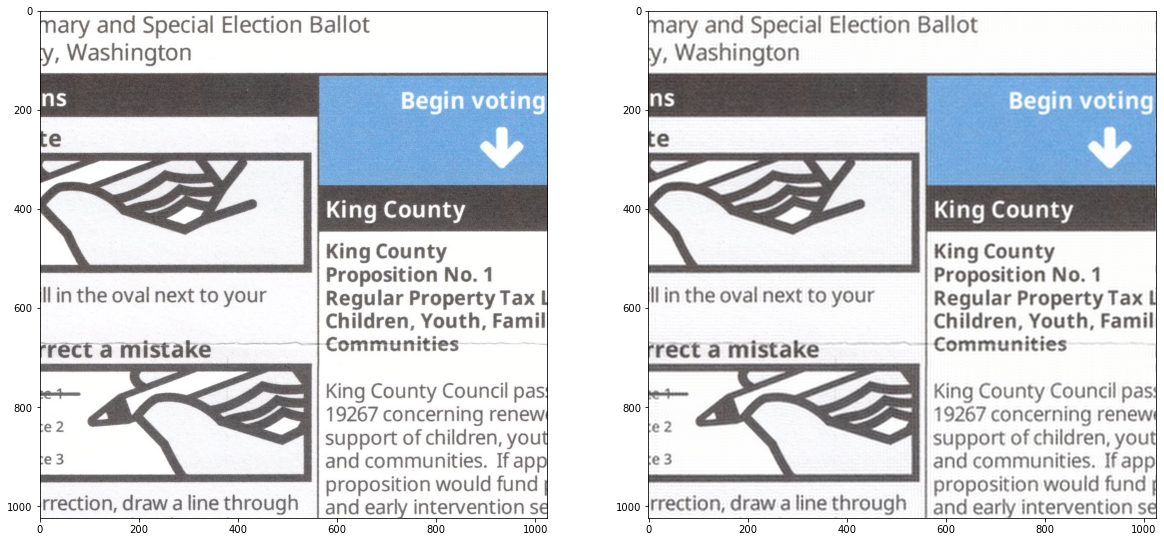

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(ballot)
ax[1].imshow(ifftn(ballot_denoised, axes=(0,1)).real.astype(int))

## Compressed sensing

In [10]:
# When image file is grayscale, imread() creates three duplicate channels
# Just keep the first
balloon = plt.imread("balloon.tif").astype(int)[:, :, 0]

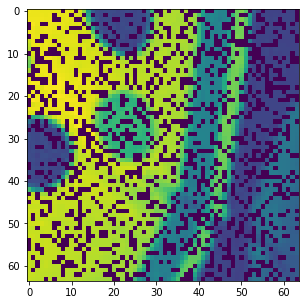

In [11]:
# Percentage of pixels we were allowed to sample
sampling_density = 0.7

# Boolean index of where samples are taken
sampling_matrix = np.random.rand(*np.zeros_like(balloon).shape) < sampling_density

# Image with sampled pixels only
sampled_image = sampling_matrix * balloon

plt.figure(figsize=(5, 5))
plt.imshow(sampled_image)

In [12]:
# Decision variable is Fourier transform coefs
dct_pred = cp.Variable(balloon.shape)

# Get the IFFT matrix with this image's dimensions
# Complex part is approx. 0
IDCT = idct(np.eye(*balloon.shape)).real

# L1 norm
objective = cp.Minimize(cp.norm(dct_pred, 1))

constraints = []
for (i, j), tf in np.ndenumerate(sampling_matrix):
    if tf:
        # IFFT of the result must agree with sampled pixels
        constraints.append( (IDCT @ dct_pred)[i, j] == sampled_image[i, j] )

# Solve
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver="SCS")

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 12 06:53:46 PM: Your problem has 4096 variables, 2827 constraints, and 0 parameters.
(CVXPY) Jul 12 06:53:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 06:53:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 12 06:53:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 12 06:53:47 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 12 06:53:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


366.5338329691717

Text(0.5, 1.0, 'best guess')

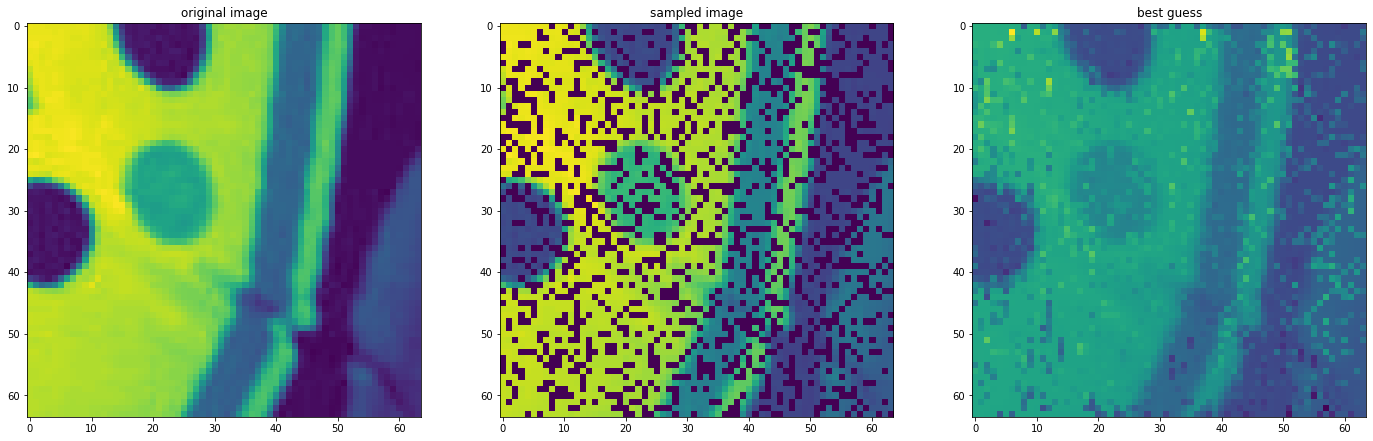

In [13]:
# Or ifftn(fft_pred.value), but for some reason that yields a different result.
predicted_img = IDCT @ dct_pred.value

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(balloon)
ax[0].set_title("original image")
ax[1].imshow(sampled_image)
ax[1].set_title("sampled image")
ax[2].imshow(np.round(predicted_img.real).astype(int))
ax[2].set_title("best guess")

In [14]:
building = plt.imread("building.tif", format="tif").astype(int)[100:300, :200, :]

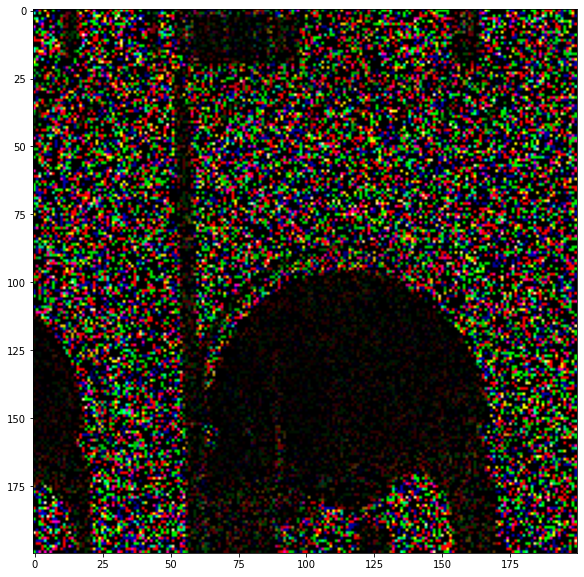

In [15]:
sampling_density = 0.2
sampling_matrix = np.random.rand(*building.shape) < sampling_density
sampled_image = sampling_matrix * building
# Vector form is building[sampling_matrix]

plt.figure(figsize=(10, 10))
plt.imshow(sampled_image)

In [16]:
res_fft_red = cp.Variable(np.zeros_like(building).shape[:2])
res_fft_blu = cp.Variable(np.zeros_like(building).shape[:2])
res_fft_grn = cp.Variable(np.zeros_like(building).shape[:2])

IDCT = idct(np.eye(*building.shape)).real
res = []
    
for ch, var in enumerate([res_fft_red, res_fft_blu, res_fft_grn][:1]):
    # L1 norm
    objective = cp.Minimize(cp.norm(var, 1))

    constraints = []
    for (i, j), tf in np.ndenumerate(sampling_matrix[:, :, ch]):
        if tf:
            # IFFT of the result must agree with sampled pixels
            constraints.append( (IDCT @ var)[i, j] == sampled_image[i, j, ch] )

    # Solve
    prob = cp.Problem(objective, constraints)
    res.append(prob.solve(verbose=True))

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 12 06:55:17 PM: Your problem has 40000 variables, 8146 constraints, and 0 parameters.
(CVXPY) Jul 12 06:55:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 06:55:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 12 06:55:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 12 06:55:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 12 06:55:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

In [20]:
predicted_fft = np.stack([i.value for i in (res_fft_red, res_fft_blu, res_fft_grn), axis=-1)
predicted_img = np.stack([IDCT @ i.value for i in (res_fft_red, res_fft_blu, res_fft_grn)], axis=-1)
plot_rgb(predicted_fft)

SyntaxError: invalid syntax (<ipython-input-20-4ddbcf1b631a>, line 1)

In [24]:
res

[inf]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(building)
ax[0].set_title("original image")
ax[1].imshow(sampled_image)
ax[1].set_title("sampled image")
ax[2].imshow(predicted_img.real.astype(int))
ax[2].set_title("best guess")

In [ ]:
np.mean(predicted_fft > 1e-4)

In [ ]:
IFFT = ifft2(np.eye(512, 512)).real

In [ ]:
g = np.random.rand(10,10)

In [ ]:
FFT = fft2(np.eye(10))

In [ ]:
plt.imshow(np.abs(fftn(g)))

In [ ]:
plt.imshow(np.abs(FFT @ g))

In [ ]:
IFFT @ res_fft_red.value

In [ ]:
IFFT = ifftn(np.eye(*np.zeros_like(building).shape[:2])).real


In [ ]:
building[:, :, 0][sampling_matrix[:, :, 0]]

In [ ]:
(IFFT @ res_fft_red.value)[sampling_matrix[:, :, 0]]

In [ ]:
np.size(building[:, :, 0][sampling_matrix[:, :, 0]])

In [ ]:
(IFFT @ res_fft_red)[sampling_matrix[:, :, 0]] == building[:, :, 0][sampling_matrix[:, :, 0]]

In [ ]:
res_fft_red.value

In [ ]:
ifftn(predicted_fft, axes=(0,1)).real[:, :, 0]

In [ ]:
np.abs(ifftn(np.eye(*np.zeros_like(building).shape[:2])).imag).sum()